# COBS Tutorial: A Walkthrough

|![contributions welcome](https://img.shields.io/badge/contributions-welcome-brightgreen.svg?style=flat)|[![License](http://img.shields.io/badge/license-MIT-green.svg?style=flat)](https://github.com/sustainable-computing/COBS/blob/master/LICENSE)|[![DOI](https://zenodo.org/badge/DOI/10.1145/3408308.3431119.svg)](https://doi.org/10.1145/3408308.3431119)
|-|-|-|


COBS is an open-source, modular building simulation platform. It facilitates the development of learning-based, occupant-centric building controls and their evaluation under different occupancy schedules and weather conditions. COBS wraps readings of building sensors in states that are defined in [EnergyPlus](https://energyplus.net/), and supports concurrent execution of control decisions on different control knobs that are available in the simulated building. 

To flatten the learning curve for Reinforcement Learning (RL) researchers and building scientists, COBS's interface is identical to OpenAI Gym. The diagram below shows its architecture.

![The architecture of COBS](https://cobs-platform.github.io/_images/cobs-architecture.png)

<a id="table-of-contents"></a>
## Table of Contents
1. [Dependencies](#installation)
2. [Before You Start](#model)
3. [Occupancy Schedules](#occupancy)
4. [Defining the MDP](#mdp)
    1. [Define your state](#state)
    2. [Wrap your action](#action)
    3. [Define your environment](#environment)
5. [Example Use Case: Joint Control of Building Systems using COBS](#example)

<a id="installation"></a>
## Dependencies

COBS is built on top of the python packages listed below. Make sure you install the specified versions of these packages. 

| Package name       | How it's used in COBS | Latest version                      | Required version |
|:-------------------|:----------------------|:-----------------------------------:|:-----------------|
| [Numpy][numpy web] | Main data structures  | [![numpy][numpy badge]][numpy link] | >= 1.16.0        |
| [Eppy][eppy web]   | Built-in models       | [![eppy][eppy badge]][eppy link]    | >= 0.5.52        |

[numpy web]: https://www.numpy.org/
[numpy badge]: https://badge.fury.io/py/numpy.svg
[numpy link]: https://badge.fury.io/py/numpy

[eppy web]: https://eppy.readthedocs.io/en/latest/Main_Tutorial.html
[eppy badge]: https://badge.fury.io/py/eppy.svg
[eppy link]: https://badge.fury.io/py/eppy

COBS requires [EnergyPlus v9.3.0](https://github.com/NREL/EnergyPlus/releases/tag/v9.3.0) 
and may not be compatible with other versions. EnergyPlus must be installed prior to using COBS.

[Back to top](#table-of-contents)

<a id="model"></a>
## Preparing a Building Model

Before using COBS to make your control agent interact with a simulated building, you must specify the building model and an input file for the weather data. The building model is typically an IDF file that describes the building, e.g., its floor plan, wall thickness and material, HVAC system components, their functional relationships, etc. The weather file must be in the EPW format. There are sample IDF and EPW files under the [./data](https://github.com/sustainable-computing/COBS/tree/master/cobs/data) directory.

You may [create your own models](https://www.energy.gov/eere/buildings/building-energy-modeling), or borrow IDF and EPW files from
1. the EnergyPlus installation directory, under ``./ExampleFiles``, ``./DataSets``, and ``./WeatherData``.
2. the [U.S. Department of Energy website](https://www.energycodes.gov/prototype-building-models) for residential and commercial buildings.

[Back to top](#table-of-contents)

<a id="occupancy"></a>
## Generating Occupancy Schedules

The IDF file normally contains occupancy information for the entire duration of the simulation. In many cases, you may want to overwrite this schedule to assess the impact of dfferent occupancy schedules on the performance of your control algorithm, measured in terms of energy cost, indoor environmental quality, and so on. To enable this, COBS has a built-in module for generating occupant movement patterns within the building and creating the building-level occupancy schedule based on the IDF file that describes the building floor plan.

This module allows for creating two types of schedules and has parameters that you can play with. Note that it is designed for commercial buildings so it synthesizes occupants' movements during business hours only.

### Schedules
1. **Fixed Schedule (Default)**: Long-term building occupants are assigned to specific private or shared offices. Thus, they spend most of their time in their office and only visit other rooms in the building for scheduled meetings and during breaks.


2. **CTMC-based Schedule**: Long-term building occupants visit all or a subset of building spaces in a probabilistic fashion. Specifically, once they visit a room, they will stay there for some amount of time. We assume that the time spent in room _i_ is exponentially distributed with mean _-1/q[i, i]_. After they leave this room, they move to another room _j_ in the building with probability _-q[i, j]/q[i, i]_. Room _j_ can be for example a room that is adjacent to Room _i_. For every occupant, the user has to provide the transition rate matrix _Q=[q]_ of the Continuous Time Markov Chain (CTMC) that describes how this occupant moves in the building. Our occupancy generator takes as input the transition rate matrices for all building occupants, generates traces (sample paths) of these stochastic processes, and determines the zone-level occupancy schedule by tracking how many occupants are in each room at any given point in time.


3. **Modified CTMC-based Schedule**: Long-term building occupants visit specific rooms during scheduled meetings and breaks (all-hands meetings and lunch time). When there is no such events, they move in the building following the CTMC-based schedule described above.


The transition rate matrix is a square matrix that looks like this:

<!-- 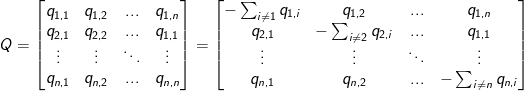 -->
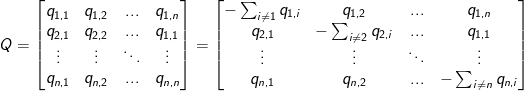

**⚠ Remark**: Note that off-diagonal elements must be non-negative. Otherwise, the _Q_ matrix will not be valid.

Each element _q[i, j]_ represents the rate of transitions from Room _i_ to Room _j_, and _n_ is the number of rooms plus two to account for the building entrance and assigned office. The diagonal elements, i.e., _q[i, i]'s_, will be replaced with values that make the row sums zero.

The last row and column correspond to transition from and to the office that is assigned to the occupant. The occupancy generator randomly assigns each occupant to a room. Suppose an occupant is assined to Room _i_, the last row and column will replace the _i_th row and column in the transition rate matrix. Once this is done, we drop the last rom and column. If all elements in the last row and column are zero, then they are dropped without any replacement.

It is worth mentioning that the occupancy generator also accepts one transition rate matrix for all occupants. 
In this case, the occupants will share the same transition rate matrix, but the last row and column are used to replace different rows and columns depending on the random office assignment.

**⚠ Remark**: The occupancy generator creates the daily schedule for each occupant, then converts these schedules to an occupancy schedule for each zone to match the EnergyPlus input format. The obtained zone-level schedules can be written to the IDF file if the flag is set (see examples below).

### Tunable parameters for all schedules
| Name | Description | Default value |
|:-----|:------------|:--------------|
|work\_start\_time|The wall-clock time denoting the start of business hour| 9:00:00 |
|work\_end\_time|The wall-clock time denoting the end of business hour| 17:00:00 |
|max_earliness|The parameter that controls the maximum earliness of an arrival/departure compared to work start/end time | 30 \* 60 s |
|cut\_off\_time|The hard deadline for occupants to come to work. If the sampled arrival time is later than this, they do not come to work| 14:00:00 |
|call\_for\_absence\_prob|The probability that a long-term occupant does not show up| 0.01 |

### Tunable parameters for scheduled events for the fixed schedule
| Name | Description | Default value |
|:-----|:------------|:--------------|
|meeting\_time|The wall-clock time when the all-hands meeting begins| 16:00:00 |
|meeting\_length\_avg|The parameter for generating all-hands meeting length (normal distribution)| 15 \* 60 s  |
|meeting\_length\_std|See above| 60 s |
|lunch\_break\_start|The wall-clock time when the lunch break starts| 12:00:00 |
|lunch\_break\_end|The wall-clock time when the lunch break ends| 13:00:00 |
|guest\_lambda|The parameter of Poisson distribution used to estimate the number of visitors per day| 3 |
|visit\_colleague\_lambda|The parameter of Poisson distribution used to estimate the number of times occupants go to other rooms| 3 |

[Back to top](#table-of-contents)

In [1]:
# Change the current working directory to the COBS installation directory
import os
os.chdir("D:\\Work\\COBS\\")

In [2]:
# A minimal example that shows how to use the CTMC-based schedule simulator
from cobs import Model
from cobs import OccupancyGenerator as OG
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# E+ installation (absolute path)
# this example shows the path in Windows, but you can specify the path in Linux too
Model.set_energyplus_folder("D:\\Software\\EnergyPlus\\")

# In this example, we use sample IDF and weather files that come with COBS
# The occupancy generator requires COBS.Model to be built in advance
model = Model(idf_file_name="cobs/data/buildings/5ZoneAirCooled.idf",
              weather_file="cobs/data/weathers/USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw")

# Let's generate the occupancy schedule with default parameters
# Note that the IDF file may already contain an occupancy schedule
# We can check the schedule of each zone (if any)
print(" ===== Before ===== ")
for zone_schedule in model.get_configuration("People"):
    print(f"Zone {zone_schedule['Zone_or_ZoneList_Name']}"
          f" is using schedule {zone_schedule['Number_of_People_Schedule_Name']}")

# Set the length of simulation to 1 day
model.set_runperiod(1, start_year=1999, specify_year=True)
# Set the number of timesteps per hour to 60, so we have minutely data
model.set_timestep(60)

occupancy = list()

# Run the experiment
state = model.reset()
with tqdm(total=model.get_total_timestep() - 1) as pbar:
    while not model.is_terminate():
        occupancy.append(state["occupancy"])
        state = model.step(None)
        pbar.update(1)

occupancy.append(state["occupancy"])
occupancy = pd.DataFrame(occupancy)

 ===== Before ===== 
Zone SPACE1-1 is using schedule OCCUPY-1
Zone SPACE2-1 is using schedule OCCUPY-1
Zone SPACE3-1 is using schedule OCCUPY-1
Zone SPACE4-1 is using schedule OCCUPY-1
Zone SPACE5-1 is using schedule OCCUPY-1


100%|█████████████████████████████████████████████████████████████████████████████| 1439/1439 [00:08<00:00, 173.86it/s]


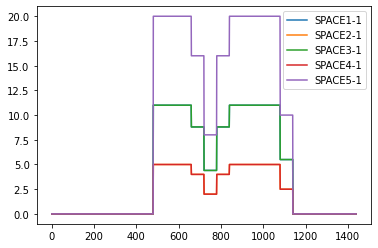

,SPACE1-1,SPACE2-1,SPACE3-1,SPACE4-1,SPACE5-1
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0


In [3]:
from IPython.display import HTML
occupancy.plot()
plt.show()
HTML(occupancy.to_html())

In [4]:
# Create an OccupancyGenerator instance based on the given model
# The floor plan and room connectivity graph will be recognized
og = OG(model, num_occupant=10)

# Initialize a transition matrix for every occupant
transition_matrix_size = len(og.possible_locations)
transition_matrix = np.zeros((transition_matrix_size, transition_matrix_size)) + 1
# Assume we want occupants to mainly stay in their own office 
transition_matrix[-1, :-1] = 1 / 50000
transition_matrix[:-1, -1] = 3

og.set_transition_matrics(transition_matrix)

# The add_to_model argument will determine whether to add the existing occupancy schedule to the model
# We can also say which occupancy schedules should be overwritten
# This method returns four instances
# 1. schedule in IDF format
# 2. location of each occupant in numpy format
# 3. number of occupants in each zone in numpy format
# 4. list of all accessible locations in the building
_, _, _, _, = og.generate_daily_schedule(add_to_model=True,
                                         overwrite_dict={f"SPACE{i}-1": f"SPACE{i}-1 People 1"
                                                         for i in range(1, 6)},
                                         use_scheduled_events=False)

# Now we can check the occupancy schedule of each zone
print(" ===== After ===== ")
for zone_schedule in model.get_configuration("People"):
    print(f"Zone {zone_schedule['Zone_or_ZoneList_Name']}"
          f" is using schedule {zone_schedule['Number_of_People_Schedule_Name']}")

occupancy = list()

# Run the experiment
state = model.reset()
with tqdm(total=model.get_total_timestep() - 1) as pbar:
    while not model.is_terminate():
        occupancy.append(state["occupancy"])
        state = model.step(None)
        pbar.update(1)

occupancy.append(state["occupancy"])
occupancy = pd.DataFrame(occupancy)

 ===== After ===== 
Zone SPACE1-1 is using schedule Generated_Schedule_Zone_SPACE1-1
Zone SPACE2-1 is using schedule Generated_Schedule_Zone_SPACE2-1
Zone SPACE3-1 is using schedule Generated_Schedule_Zone_SPACE3-1
Zone SPACE4-1 is using schedule Generated_Schedule_Zone_SPACE4-1
Zone SPACE5-1 is using schedule Generated_Schedule_Zone_SPACE5-1
Zone PLENUM-1 is using schedule Generated_Schedule_Zone_PLENUM-1


100%|█████████████████████████████████████████████████████████████████████████████| 1439/1439 [00:07<00:00, 191.61it/s]


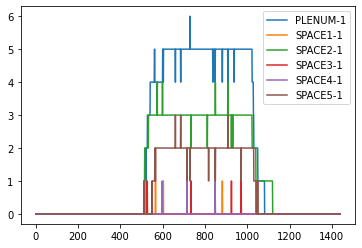

,PLENUM-1,SPACE1-1,SPACE2-1,SPACE3-1,SPACE4-1,SPACE5-1
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
occupancy.plot()
plt.show()
HTML(occupancy.to_html())

<a id="mdp"></a>
## Defining the Markov Decision Process (MDP)
COBS has an interface that is similar to [OpenAI Gym](http://gym.openai.com/). Thus, you can use COBS.Model just as you use a gym environment. The only difference is that in COBS you must define the state and wrap the action. This is because the list of available sensors and actuators depend on the building.

[Back to top](#table-of-contents)

<a id="state"></a>
### State Definition
The state should only contain data that is accessible from EnergyPlus during simulation. You can find what data is available during the simulation in two places:
1. The IDF file you use. All `Output:Variable` objects are accessible in the simulation.
2. The `*.rdd` file generated during the simulation. You can run the simulation for a short period of time to let EnergyPlus generate this file. Note that not all data in the `*.rdd` file is accessible in every timestep.

COBS has a built-in method to list all `Output:Variable` objects in the IDF file (`COBS.Model.get_possible_state_variables()`), but it does not have any function to help you find the state variables that are available in the `*.rdd` file. The `*.rdd` file looks like this:

>Program Version,EnergyPlus, Version 9.3.0-baff08990c, YMD=2021.11.04 14:33,
>
>Var Type (reported time step),Var Report Type,**Variable Name** [Units]
>
>Zone,Average,**Site Outdoor Air Drybulb Temperature** [C]
>
>Zone,Average,**Site Outdoor Air Dewpoint Temperature** [C]
>
>...

This tells you the variable name. You need to go back to your IDF file and find the IDF object you are looking for.

_**⚠ Remark**: Each state variable is defined by a tuple (variable name, corresponding IDF object)._

-----

By default, all valid `Output:Variable` objects defined in the IDF file will become part of the state. You can modify this using these methods:
1. `COBS.Model.select_state_variables(entry=None, index=None)`
2. `COBS.Model.add_state_variables(entry)`
3. `COBS.Model.remove_state_variables(entry)`
4. `COBS.Model.pop_state_variables(index)`

The parameter `entry` could be one tuple or a list of tuples, and the parameter `index` can be an integer or a list of integers.

[Code examples](#code-existing-state)

Another way to define the state variables is to provide the `eplus_naming_dict` argument when you are defining the model `COBS.Model`, or edit `COBS.Model.eplus_naming_dict` to declare the state variables in the experiment. It is a dictionary with the following format:
```python
{
    ('Zone Thermal Comfort Fanger Model PMV', 'SPACE1-1 People 1'): "PMV Zone 1",
    ('Lights Electric Power', 'SPACE1-1 Lights 1'): 'Lights Zone 1',
    ...
}
```

Each key in this dictionary is a tuple with two elements, namely the output variable name that can be found in the `*.rdd` file, and the object name. The corresponding value is a user-defined name to describe the selected variable. This will be used as the key when you get the state values from the environment. However, you still have to make sure these variables are defined in the IDF file, otherwise you will need to add them to the model.

[Code examples](#code-new-state)

COBS includes some common variables in the state by default. These variables are as follows:
1. Current timestep (timestep)
2. Current datetime (time)
3. Zone average temperature in each zone (temperature)
4. The number of occupants in each zone at this time (occupancy)
5. Energy consumption at this time (energy)

These can be used without defining `Output:Variable` objects in the IDF file.

[Back to top](#table-of-contents)

<a id="code-existing-state"></a>
#### Code for using the existing variables

In [6]:
# This is a minimal example to demonstrate how you can choose the state variables 
# that are already defined in the IDF file
from pprint import pprint
from cobs import Model

# E+ installation (absolute path)
# this example shows the path in Windows, but you can specify the path in Linux too
Model.set_energyplus_folder("D:\\Software\\EnergyPlus\\")

# We use sample IDF and weather files included in COBS
model = Model(idf_file_name="cobs/data/buildings/5ZoneAirCooled.idf",
              weather_file="cobs/data/weathers/USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw")

# Check all available states in the IDF file
pprint(model.get_current_state_variables())

[('System Node Dewpoint Temperature', 'Mixed Air Node 1'),
 ('System Node Humidity Ratio', 'Mixed Air Node 1'),
 ('System Node Humidity Ratio', 'OA Heating Coil 1 Air Outlet Node'),
 ('System Node Humidity Ratio', 'OA Mixing Box 1 Inlet Node'),
 ('System Node Humidity Ratio', 'VAV Sys 1 Outlet Node'),
 ('System Node Mass Flow Rate', 'Main Cooling Coil 1 Water Inlet Node'),
 ('System Node Mass Flow Rate', 'Main Heating Coil 1 Water Inlet Node'),
 ('System Node Mass Flow Rate', 'OA Cooling Coil 1 Water Inlet Node'),
 ('System Node Mass Flow Rate', 'OA Heating Coil 1 Air Outlet Node'),
 ('System Node Mass Flow Rate', 'OA Heating Coil 1 Water Inlet Node'),
 ('System Node Mass Flow Rate', 'OA Mixing Box 1 Inlet Node'),
 ('System Node Mass Flow Rate', 'VAV Sys 1 Outlet Node'),
 ('System Node Setpoint Temperature', 'OA Heating Coil 1 Air Outlet Node'),
 ('System Node Setpoint Temperature', 'OA Mixing Box 1 Inlet Node'),
 ('System Node Setpoint Temperature', 'VAV Sys 1 Outlet Node'),
 ('System

In [7]:
# Let's just select three of them as our state variables
model.select_state_variables(index=[0, 1, 5])
pprint(model.get_current_state_variables())

[('System Node Dewpoint Temperature', 'Mixed Air Node 1'),
 ('System Node Humidity Ratio', 'Mixed Air Node 1'),
 ('System Node Mass Flow Rate', 'Main Cooling Coil 1 Water Inlet Node')]


In [8]:
# You can use the tuple to add/delete state variables
model.add_state_variables(('System Node Temperature', 'Mixed Air Node 1'))
pprint(model.get_current_state_variables())

[('System Node Dewpoint Temperature', 'Mixed Air Node 1'),
 ('System Node Humidity Ratio', 'Mixed Air Node 1'),
 ('System Node Mass Flow Rate', 'Main Cooling Coil 1 Water Inlet Node'),
 ('System Node Temperature', 'Mixed Air Node 1')]


In [9]:
# Run the experiment with the selected state variables
# To reduce the running time, we just simulate for one day
model.set_runperiod(1)
# Using 30-minute timesteps
model.set_timestep(2)

# Run the experiment
state = model.reset()
while not model.is_terminate():
    pprint(state)
    state = model.step(None)

pprint(state)
print("Done")

{'System Node Dewpoint Temperature_Mixed Air Node 1': 0.0,
 'System Node Humidity Ratio_Mixed Air Node 1': 0.001866002022339802,
 'System Node Mass Flow Rate_Main Cooling Coil 1 Water Inlet Node': 0.0,
 'System Node Temperature_Mixed Air Node 1': 15.435362078079983,
 'energy': 0.0,
 'occupancy': {'SPACE1-1': 0.0,
               'SPACE2-1': 0.0,
               'SPACE3-1': 0.0,
               'SPACE4-1': 0.0,
               'SPACE5-1': 0.0},
 'temperature': {'PLENUM-1': 15.689583476021653,
                 'SPACE1-1': 17.310843051827728,
                 'SPACE2-1': 17.341444224351044,
                 'SPACE3-1': 17.313006562227415,
                 'SPACE4-1': 17.31802688065112,
                 'SPACE5-1': 19.00849530542632},
 'terminate': False,
 'time': datetime.datetime(1986, 1, 1, 0, 30),
 'timestep': 0}
{'System Node Dewpoint Temperature_Mixed Air Node 1': -8.504943233535409,
 'System Node Humidity Ratio_Mixed Air Node 1': 0.0018641129328823538,
 'System Node Mass Flow Rate_Main 

                 'SPACE5-1': 18.467512253528266},
 'terminate': False,
 'time': datetime.datetime(1986, 1, 1, 10, 30),
 'timestep': 20}
{'System Node Dewpoint Temperature_Mixed Air Node 1': -9.857530964053305,
 'System Node Humidity Ratio_Mixed Air Node 1': 0.0016505310722605448,
 'System Node Mass Flow Rate_Main Cooling Coil 1 Water Inlet Node': 0.0,
 'System Node Temperature_Mixed Air Node 1': 14.19499354192867,
 'energy': 2446690.6969813188,
 'occupancy': {'SPACE1-1': 0.0,
               'SPACE2-1': 0.0,
               'SPACE3-1': 0.0,
               'SPACE4-1': 0.0,
               'SPACE5-1': 0.0},
 'temperature': {'PLENUM-1': 14.600355095127794,
                 'SPACE1-1': 18.09457786885224,
                 'SPACE2-1': 20.990742124842694,
                 'SPACE3-1': 16.965849988375176,
                 'SPACE4-1': 16.952120689870007,
                 'SPACE5-1': 18.506121785637106},
 'terminate': False,
 'time': datetime.datetime(1986, 1, 1, 11, 0),
 'timestep': 21}
{'System No

 'System Node Mass Flow Rate_Main Cooling Coil 1 Water Inlet Node': 0.0,
 'System Node Temperature_Mixed Air Node 1': 15.84016726157079,
 'energy': 1395713.0826110784,
 'occupancy': {'SPACE1-1': 0.0,
               'SPACE2-1': 0.0,
               'SPACE3-1': 0.0,
               'SPACE4-1': 0.0,
               'SPACE5-1': 0.0},
 'temperature': {'PLENUM-1': 16.06370350933988,
                 'SPACE1-1': 17.6025618829244,
                 'SPACE2-1': 17.62244783739724,
                 'SPACE3-1': 17.522148752115093,
                 'SPACE4-1': 17.563596806994596,
                 'SPACE5-1': 19.163549375479466},
 'terminate': False,
 'time': datetime.datetime(1986, 1, 1, 20, 30),
 'timestep': 40}
{'System Node Dewpoint Temperature_Mixed Air Node 1': -8.963851069489635,
 'System Node Humidity Ratio_Mixed Air Node 1': 0.0017919927704540919,
 'System Node Mass Flow Rate_Main Cooling Coil 1 Water Inlet Node': 0.0,
 'System Node Temperature_Mixed Air Node 1': 15.767865093417718,
 'energy': 

<a id="code-new-state"></a>
#### Code for using state variables that are not defined in IDF files

In [10]:
"""
This is an example of how to add your own states using COBS.
We show two new states: VAV position and CO2 concentration
"""
from cobs import Model
from pprint import pprint
from tqdm import tqdm
import matplotlib.pyplot as plt

Model.set_energyplus_folder("D:\\Software\\EnergyPlus\\")

# A dictionary formatted as {target sensor: state name}
# The target sensor is a tuple: (variable name, key value)
eplus_extra_states = {("Zone Air Terminal VAV Damper Position", "SPACE1-1 VAV Reheat"): "Space 1-1 VAV",
                      ("Zone Air Terminal VAV Damper Position", "SPACE2-1 VAV Reheat"): "Space 2-1 VAV",
                      ("Zone Air CO2 Concentration", "SPACE1-1"): "SPACE1-1 CO2",
                      ("Zone Air CO2 Concentration", "SPACE2-1"): "SPACE2-1 CO2"}

model = Model(idf_file_name="cobs/data/buildings/5ZoneAirCooled.idf",
              weather_file="cobs/data/weathers/USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw",
              eplus_naming_dict=eplus_extra_states)

# Add these sensors to the IDF file (optional, if IDF already contains them, you can ignore it)
for key, _ in eplus_extra_states.items():
    model.add_configuration("Output:Variable",
                            {"Key Value": key[1], "Variable Name": key[0], "Reporting Frequency": "Timestep"})

# Add simulation of CO2 concentration. It is not included in 5ZoneAirCooled.idf, so I add it here
# You have to provide outdoor CO2 concentration for Energyplus to calculate indoor CO2 concentration
# Here I use 410.25 ppm as the outdoor CO2 level
model.add_configuration("Schedule:Constant",
                        {"Name": "Outdoor CO2 Schedule",
                         "Schedule Type Limits Name": "Any Number",
                         "Hourly Value": 410.25})
model.add_configuration("ZoneAirContaminantBalance",
                        {"Carbon Dioxide Concentration": "Yes",
                         "Outdoor Carbon Dioxide Schedule Name": "Outdoor CO2 Schedule"})

# Check current available state variables
pprint(model.get_current_state_variables())

[('System Node Dewpoint Temperature', 'Mixed Air Node 1'),
 ('System Node Humidity Ratio', 'Mixed Air Node 1'),
 ('System Node Humidity Ratio', 'OA Heating Coil 1 Air Outlet Node'),
 ('System Node Humidity Ratio', 'OA Mixing Box 1 Inlet Node'),
 ('System Node Humidity Ratio', 'VAV Sys 1 Outlet Node'),
 ('System Node Mass Flow Rate', 'Main Cooling Coil 1 Water Inlet Node'),
 ('System Node Mass Flow Rate', 'Main Heating Coil 1 Water Inlet Node'),
 ('System Node Mass Flow Rate', 'OA Cooling Coil 1 Water Inlet Node'),
 ('System Node Mass Flow Rate', 'OA Heating Coil 1 Air Outlet Node'),
 ('System Node Mass Flow Rate', 'OA Heating Coil 1 Water Inlet Node'),
 ('System Node Mass Flow Rate', 'OA Mixing Box 1 Inlet Node'),
 ('System Node Mass Flow Rate', 'VAV Sys 1 Outlet Node'),
 ('System Node Setpoint Temperature', 'OA Heating Coil 1 Air Outlet Node'),
 ('System Node Setpoint Temperature', 'OA Mixing Box 1 Inlet Node'),
 ('System Node Setpoint Temperature', 'VAV Sys 1 Outlet Node'),
 ('System

100%|███████████████████████████████████████████████████████████████████████████████| 479/479 [00:03<00:00, 148.05it/s]

{'SPACE1-1 CO2': 788.4153498790545,
 'SPACE2-1 CO2': 794.5009497948214,
 'Space 1-1 VAV': 0.3,
 'Space 2-1 VAV': 0.3,
 'System Node Dewpoint Temperature_Mixed Air Node 1': 1.0977314980974429,
 'System Node Humidity Ratio_Mixed Air Node 1': 0.004185270256151848,
 'System Node Humidity Ratio_OA Heating Coil 1 Air Outlet Node': 0.0029943091930087523,
 'System Node Humidity Ratio_OA Mixing Box 1 Inlet Node': 0.0029943091930087523,
 'System Node Humidity Ratio_VAV Sys 1 Outlet Node': 0.004185270256151848,
 'System Node Mass Flow Rate_Main Cooling Coil 1 Water Inlet Node': 0.0,
 'System Node Mass Flow Rate_Main Heating Coil 1 Water Inlet Node': 0.0,
 'System Node Mass Flow Rate_OA Cooling Coil 1 Water Inlet Node': 0.0,
 'System Node Mass Flow Rate_OA Heating Coil 1 Air Outlet Node': 0.00621144618492455,
 'System Node Mass Flow Rate_OA Heating Coil 1 Water Inlet Node': 0.0,
 'System Node Mass Flow Rate_OA Mixing Box 1 Inlet Node': 0.00621144618492455,
 'System Node Mass Flow Rate_VAV Sys 1 Ou

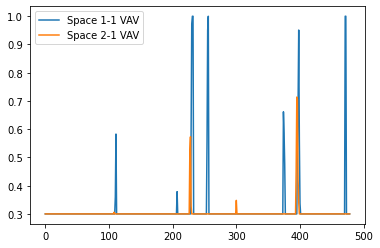

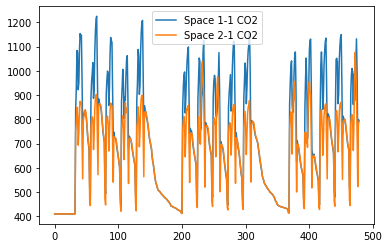

In [11]:
# Simulate for 20 day, 60-minute timesteps
model.set_runperiod(20)
model.set_timestep(1)

# Store values for visualization
vav_1_pos = list()
vav_2_pos = list()

co2_1 = list()
co2_2 = list()

state = model.reset()

# Run simulation
with tqdm(total=model.get_total_timestep() - 1) as pbar:
    while not model.is_terminate():
        vav_1_pos.append(state["Space 1-1 VAV"])
        vav_2_pos.append(state["Space 2-1 VAV"])
        co2_1.append(state["SPACE1-1 CO2"])
        co2_2.append(state["SPACE2-1 CO2"])

        state = model.step(None)
        pbar.update(1)

# Show what is included in the state
pprint(state)

# Plot the result
plt.plot(vav_1_pos, label="Space 1-1 VAV")
plt.plot(vav_2_pos, label="Space 2-1 VAV")
plt.legend()
plt.show()

plt.plot(co2_1, label="Space 1-1 CO2")
plt.plot(co2_2, label="Space 2-1 CO2")
plt.legend()
plt.show()

<a id="action"></a>
### Wrapping your action

By using COBS, you can take many types of actions, such as changing the control setpoint, or even directly overwriting sensor readings (although it is not recommended). To perform a valid action, you have to know the actuator name beforehand. You need to provide the IDF object type, control type, and the key for the corresponding IDF object. These three pieces of information can be retrieved from the `*.edd` file after a successful run. If you don't have this `*.edd` file generated after the experiment, try adding the following in your IDF file and run the experiment again.
>```
>Output:EnergyManagementSystem,
>    Verbose,    ! Actuator Availability Dictionary Reporting
>    Verbose,    ! Internal Variable Availability Dictionary Reporting
>    ErrorsOnly; ! EnergyPlus Runtime Language Debug Output Level
>```

The `*.edd` file will look like this:
>! <EnergyManagementSystem:Actuator Available>, **Component Unique Name**, **Component Type**,  **Control Type**, Units
>
>EnergyManagementSystem:Actuator Available,**Environment**,**Weather Data**,**Outdoor Dry Bulb**,[C]
>
>EnergyManagementSystem:Actuator Available,**Environment**,**Weather Data**,**Outdoor Dew Point**,[C]
>
>EnergyManagementSystem:Actuator Available,**Environment**,**Weather Data**,**Outdoor Relative Humidity**,[%]
>
>...

where the **component type** is the IDF object type and **Component Unique Name** is the key of the corresponding IDF object.

Usually we generate an empty schedule and link it to the object we want to control, and then modify the value inside this schedule to control the setpoint.

Each timestep, the environment takes a list of actions. Each action should be presented as a dictionary with this format:
```python
{
    "value": 10,                          # Set to what value
    "start_time": state["timestep"] + 1,  # When this action will be triggered (in timestep)
    "end_time": state["timestep"] + 2,    # (optional) When this action will be discarded (in timestep)
    "priority": 0,                        # The priority of this action, lower means higher priority
    "component_type": "Weather Data",     # Component Type in *.edd file
    "control_type": "Outdoor Dry Bulb",   # Control Type in *.edd file
    "actuator_key": "Environment"         # Component Unique Name in *.edd file
}
```

In case there is a conflict, the action with higher priority (lower priority value) will be performed.

[Back to top](#table-of-contents)

100%|███████████████████████████████████████████████████████████████████████████████| 479/479 [00:02<00:00, 176.83it/s]


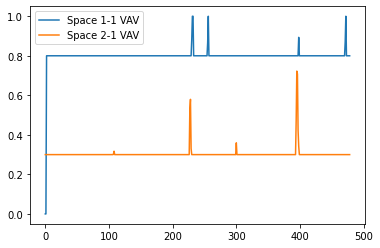

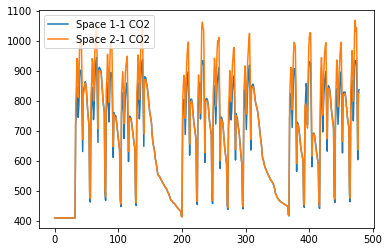

In [12]:
# This is the same example as before, but here we add a control for the VAV position in SPACE 1-1
from cobs import Model
from pprint import pprint
from tqdm import tqdm
import matplotlib.pyplot as plt

Model.set_energyplus_folder("D:\\Software\\EnergyPlus\\")

eplus_extra_states = {("Zone Air Terminal VAV Damper Position", "SPACE1-1 VAV Reheat"): "Space 1-1 VAV",
                      ("Zone Air Terminal VAV Damper Position", "SPACE2-1 VAV Reheat"): "Space 2-1 VAV",
                      ("Zone Air CO2 Concentration", "SPACE1-1"): "SPACE1-1 CO2",
                      ("Zone Air CO2 Concentration", "SPACE2-1"): "SPACE2-1 CO2"}

model = Model(idf_file_name="cobs/data/buildings/5ZoneAirCooled.idf",
              weather_file="cobs/data/weathers/USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw",
              eplus_naming_dict=eplus_extra_states)

for key, _ in eplus_extra_states.items():
    model.add_configuration("Output:Variable",
                            {"Key Value": key[1], "Variable Name": key[0], "Reporting Frequency": "Timestep"})

model.add_configuration("Schedule:Constant",
                        {"Name": "Outdoor CO2 Schedule",
                         "Schedule Type Limits Name": "Any Number",
                         "Hourly Value": 410.25})
model.add_configuration("ZoneAirContaminantBalance",
                        {"Carbon Dioxide Concentration": "Yes",
                         "Outdoor Carbon Dioxide Schedule Name": "Outdoor CO2 Schedule"})

# ===== NEW CODE =====
# Because the SPACE1-1 VAV Customized Schedule does not exist (I added to control the VAV), so add to the IDF
model.add_configuration("Schedule:Constant",
                        {"Name": "SPACE1-1 VAV Customized Schedule",
                         "Schedule Type Limits Name": "Fraction",
                         "Hourly Value": 0})

# Overwrite existing VAV control policy to get control over the minimum VAV position
model.edit_configuration(idf_header_name="AirTerminal:SingleDuct:VAV:Reheat",
                         identifier={"Name": "SPACE1-1 VAV Reheat"},
                         update_values={"Zone Minimum Air Flow Input Method": "Scheduled",
                                        "Minimum Air Flow Fraction Schedule Name": "SPACE1-1 VAV Customized Schedule"})
# ===== END OF NEW CODE =====

model.set_runperiod(20)
model.set_timestep(1)

# Store values for visualization
vav_1_pos = list()
vav_2_pos = list()
co2_1 = list()
co2_2 = list()

# ===== NEW CODE =====
vav_1_stpt = 0.8  # In this example, I force the SPACE1-1 VAV to 80% open at all times
# ===== END OF NEW CODE =====

state = model.reset()

# Run simulation
with tqdm(total=model.get_total_timestep() - 1) as pbar:
    while not model.is_terminate():
        vav_1_pos.append(state["Space 1-1 VAV"])
        vav_2_pos.append(state["Space 2-1 VAV"])
        co2_1.append(state["SPACE1-1 CO2"])
        co2_2.append(state["SPACE2-1 CO2"])

        # ===== NEW CODE =====
        # Define our actions
        actions = list()
        actions.append({"priority": 0,
                        "component_type": "Schedule:Constant",
                        "control_type": "Schedule Value",
                        "actuator_key": "SPACE1-1 VAV Customized Schedule",
                        "value": vav_1_stpt,
                        "start_time": state['timestep'] + 1})
        state = model.step(actions)
        # ===== END OF NEW CODE =====
        pbar.update(1)

# Visualize the result
plt.plot(vav_1_pos, label="Space 1-1 VAV")
plt.plot(vav_2_pos, label="Space 2-1 VAV")
plt.legend()
plt.show()

plt.plot(co2_1, label="Space 1-1 CO2")
plt.plot(co2_2, label="Space 2-1 CO2")
plt.legend()
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 1439/1439 [00:08<00:00, 169.15it/s]


Total energy used: 633474197.1800121J (175.97 kWh)


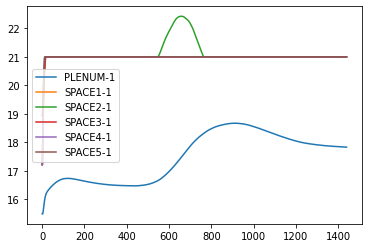

In [13]:
# Example 2 - Change the zonal heating and cooling setpoint
from cobs import Model
from pprint import pprint
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

Model.set_energyplus_folder("D:\\Software\\EnergyPlus\\")

model = Model(idf_file_name="cobs/data/buildings/5ZoneAirCooled.idf",
              weather_file="cobs/data/weathers/USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw")

state = model.reset()
# This time we log the total energy consumption of the building
total_energy = 0
# Let's plot the room temperature to see if it follows the setpoint
temperatures = list()

with tqdm(total=model.get_total_timestep() - 1) as pbar:
    while not model.is_terminate():
        total_energy += state["energy"]
        temperatures.append(state["temperature"])
        
        # Generate actions to control all setpoints
        actions = list()
        for zone, temp in state["temperature"].items():
            
            # The PLENUM-1 has no heating/cooling system, so ignore it
            if zone == "PLENUM-1":
                continue
            
            # Assuming we want to keep the temperature between 21 and 23 degrees Celsius
            actions.append({"value": 23,
                            "start_time": state["timestep"] + 1,
                            "priority": 0,
                            "component_type": "Zone Temperature Control",
                            "control_type": "Cooling Setpoint",
                            "actuator_key": zone})
            actions.append({"value": 21,
                            "start_time": state["timestep"] + 1,
                            "priority": 0,
                            "component_type": "Zone Temperature Control",
                            "control_type": "Heating Setpoint",
                            "actuator_key": zone})
        state = model.step(actions)
        pbar.update(1)

total_energy += state["energy"]
temperatures.append(state["temperature"])

# Visualize the result
print(f"Total energy used: {total_energy}J ({total_energy / 3600000:.2f} kWh)")
pd.DataFrame(temperatures).plot()
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 1439/1439 [00:07<00:00, 198.71it/s]


Total energy used: 104017375.7172054J (28.89 kWh)


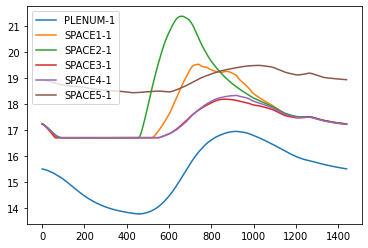

In [14]:
# Repeat the experiment where we do not control the setpoint this time
state = model.reset()
total_energy = 0
temperatures = list()
with tqdm(total=model.get_total_timestep() - 1) as pbar:
    while not model.is_terminate():
        total_energy += state["energy"]
        temperatures.append(state["temperature"])
        state = model.step(None)
        pbar.update(1)

total_energy += state["energy"]
temperatures.append(state["temperature"])

print(f"Total energy used: {total_energy}J ({total_energy / 3600000:.2f} kWh)")
pd.DataFrame(temperatures).plot()
plt.show()

<a id="environment"></a>
### Defining the environment

After the state and action are defined properly, we need to tweak some environment parameters, such as the experiment duration and the number of timesteps per hour. We can do this using these methods:
1. `COBS.Model.set_runperiod(days)`
2. `COBS.Model.set_timestep(timestep_per_hour)`

It is also possible to specify the starting year, month, day of the experiment. Details can be found [here](https://cobs-platform.github.io/modules.html#cobs.model.Model.set_runperiod).

You can also let COBS calculate the reward and return it in the state. However, this method does not work inside the Jupyter Notebook. Please try the code in a `*.py` file instead.

[Back to top](#table-of-contents)

In [15]:
# Example shows how to change experiment settings
from cobs import Model
from tqdm import tqdm

Model.set_energyplus_folder("D:\\Software\\EnergyPlus\\")

model = Model(idf_file_name="cobs/data/buildings/5ZoneAirCooled.idf",
              weather_file="cobs/data/weathers/USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw")

# a 20-day simulation starting from 7 June 2021
model.set_runperiod(20, start_year=2021, start_month=6, start_day=7, specify_year=True)
model.set_timestep(10)

# Remove all state variables because we do not need them
model.select_state_variables()
print(f"Selected state variables: {model.get_current_state_variables()}")

# Run the experiment and log the reward
state = model.reset()
print(f"Experiment start date {state['time']}")

with tqdm(total=model.get_total_timestep() - 1) as pbar:
    while not model.is_terminate():
        state = model.step(None)
        pbar.update(1)

print(f"Experiment end date {state['time']}")

Selected state variables: []


  1%|▍                                                                              | 29/4799 [00:00<00:16, 285.07it/s]

Experiment start date 1979-06-07 00:06:00


100%|█████████████████████████████████████████████████████████████████████████████| 4799/4799 [00:17<00:00, 273.32it/s]

Experiment end date 1979-06-27 00:00:00


In [ ]:
# Example shows how to define reward. Please run this as a *.py file
from cobs import Model
from cobs import OccupancyGenerator as OG
import numpy as np

class TestReward:
    def reward(self, state, actions):
        return state["timestep"] * 2

Model.set_energyplus_folder("D:\\Software\\EnergyPlus\\")

if __name__ == '__main__':

    model = Model(idf_file_name="data/buildings/5ZoneAirCooled.idf",
                  weather_file="data/weathers/USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw",
                  reward=TestReward())
    model.reset()
    while not model.is_terminate():
        state = model.step(None)
    print(state)

<a id="example"></a>
## Example of Building Joint Control using COBS

We present another GitHub repository from our previous work [**On the Joint Control of Multiple Building Systems with Reinforcement Learning**](https://github.com/sustainable-computing/COBS-joint-control). This paper explores rule-based and RL-based control of building subsystems (HVAC, lighting, shading) in a 5-zone office building in Pittsburgh, Pennsylvania in January (heating season) and July (cooling season). The floor area of this building is 5,000 square feet. The control setpoints that we adjust using different algorithms to maximize energy savings, thermal comfort, and visual comfort are supply air temperature setpoint and blind angle setpoint. [This IDF file](https://github.com/sustainable-computing/COBS-joint-control/blob/master/eplus_files/5Zone_Control_SAT_no_windowcontrol.idf) describes the simulated building. COBS is used in this work to programmatically execute rule-based control scenarios and to train the RL agents. The office building we control is depicted in the figure below.
![building-layout](https://github.com/sustainable-computing/COBS-joint-control/raw/master/building_schematic.png)

[Back to top](#table-of-contents)